In [1]:
import numpy as np
import cv2

def bboxes_SAM_from_yolo(x_center, y_center, w, h, img_w, img_h):
    x1 = (x_center - w / 2) * img_w
    y1 = (y_center - h / 2) * img_h
    x2 = (x_center + w / 2) * img_w
    y2 = (y_center + h / 2) * img_h
    return np.array([x1, y1, x2, y2])

def boxes_sam_one_pic(
    one_image_path: str,
    one_label_path: str
):
    image = cv2.imread(one_image_path)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, channels = image.shape  # height - высота, width - ширина
    elif len(image.shape) == 2:
        height, width = image.shape
    with open(one_label_path, "r") as bb_file:
        boxes = bb_file.read().split("\n")
    default_boxes = []  # list of lists
    for one_box in boxes:
        box_list = list(map(float, one_box.split(" ")))
        default_boxes.append(
            bboxes_SAM_from_yolo(box_list[1], box_list[2], box_list[3], box_list[4], width, height)
        )  # changing the order for augmentation
    return default_boxes

In [2]:
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth # vit_l # другие веса
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth # vit_b # другие веса

In [3]:
# pip install git+https://github.com/facebookresearch/segment-anything.git
# !mkdir -p models_weights
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P models_weights # 2.4gb

In [4]:
import os
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import supervision as sv
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "./models_weights/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

./models_weights/sam_vit_h_4b8939.pth ; exist: True


In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [8]:
def xyxy_to_yolov8(x1, y1, x2, y2, width, height):
    w = (x2 - x1) / width
    h = (y2 - y1) / height
    x_center = (x2 + x1) / (2 * width)
    y_center = (y2 + y1) / (2 * height)
    return x_center, y_center, w, h

In [9]:
def segment_one_image(
    ID_CLASS_PERSON_NEW: int,
    one_image_path: str,
    one_label_path: str,
    one_label_seg_path: str,
    figsize: tuple,
    show_plots: bool = False
):

    image_bgr = cv2.imread(one_image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(image_rgb)

    bboxes_one_image = boxes_sam_one_pic(one_image_path, one_label_path)

    if show_plots:
        masks_all = np.zeros((image_rgb.shape[0], image_rgb.shape[1]))
    correct_new_boxes = []
    for one_bbox_aug in bboxes_one_image:
        masks, scores, logits = mask_predictor.predict(
            box=one_bbox_aug, multimask_output=True
        )
        if show_plots:
            box_annotator = sv.BoxAnnotator(color=sv.Color.RED)
            mask_annotator = sv.MaskAnnotator(
                color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX
            )

        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks), mask=masks)
        detections = detections[detections.area == np.max(detections.area)]
        x_center, y_center, w, h = xyxy_to_yolov8(
            detections.xyxy[0][0],
            detections.xyxy[0][1],
            detections.xyxy[0][2],
            detections.xyxy[0][3],
            image_rgb.shape[1],
            image_rgb.shape[0]
            
        )
        new_correct_line = f"{ID_CLASS_PERSON_NEW} {x_center} {y_center} {w} {h}"
        correct_new_boxes.append(new_correct_line)
        if show_plots:
            masks_all += detections.mask.squeeze()

            source_image = box_annotator.annotate(
                scene=image_bgr.copy(), detections=detections, skip_label=True
            )
            segmented_image = mask_annotator.annotate(
                scene=image_bgr.copy(), detections=detections
            )

            sv.plot_images_grid(
                images=[source_image, segmented_image],
                grid_size=(1, 2),
                titles=["source image", "segmented image"],
                size=figsize,
            )
    with open(one_label_seg_path, "w") as file:
        file.write("\n".join(correct_new_boxes))
    if show_plots:    
        image_final = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
        red_color = np.array([255, 0, 0], dtype=np.uint8)
        image_final[masks_all == 1] = red_color
        plt.figure(figsize=(20, 10))
        plt.imshow(image_final)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


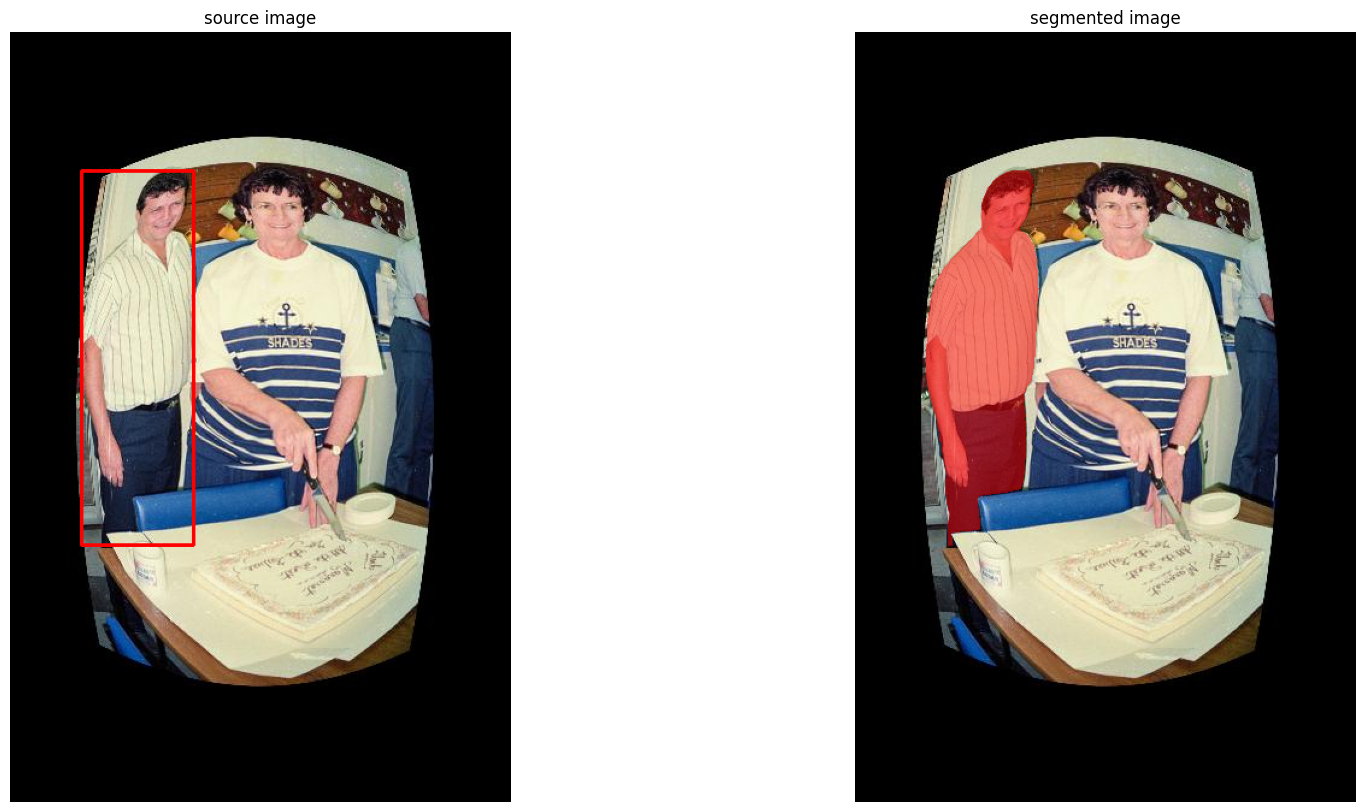

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


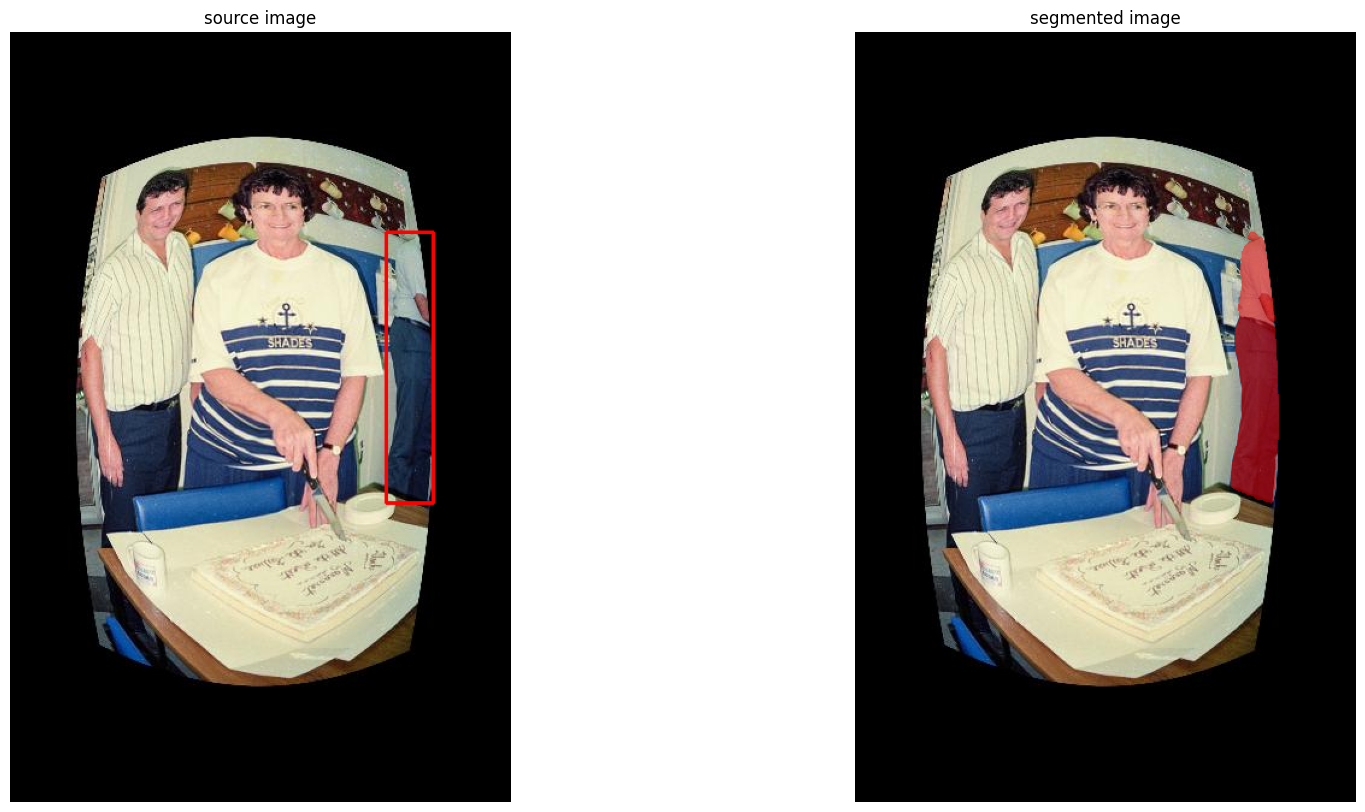

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


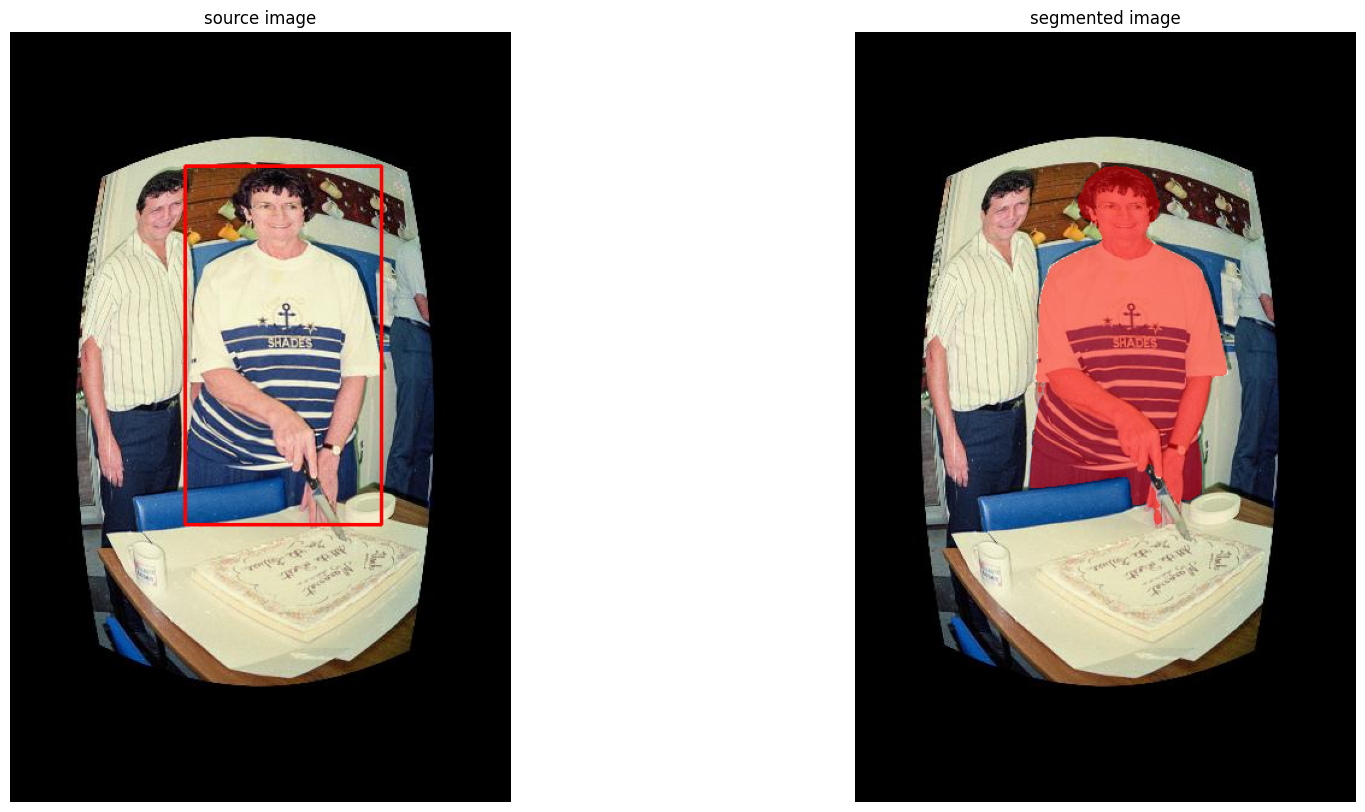

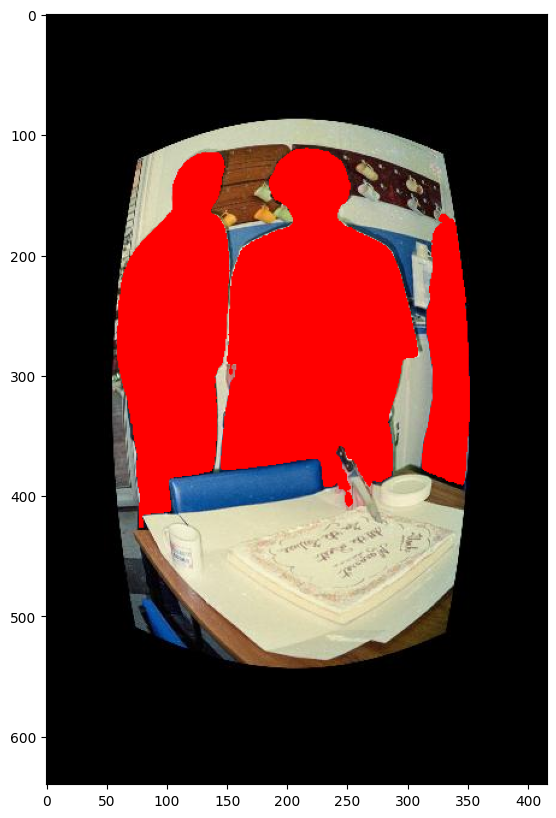

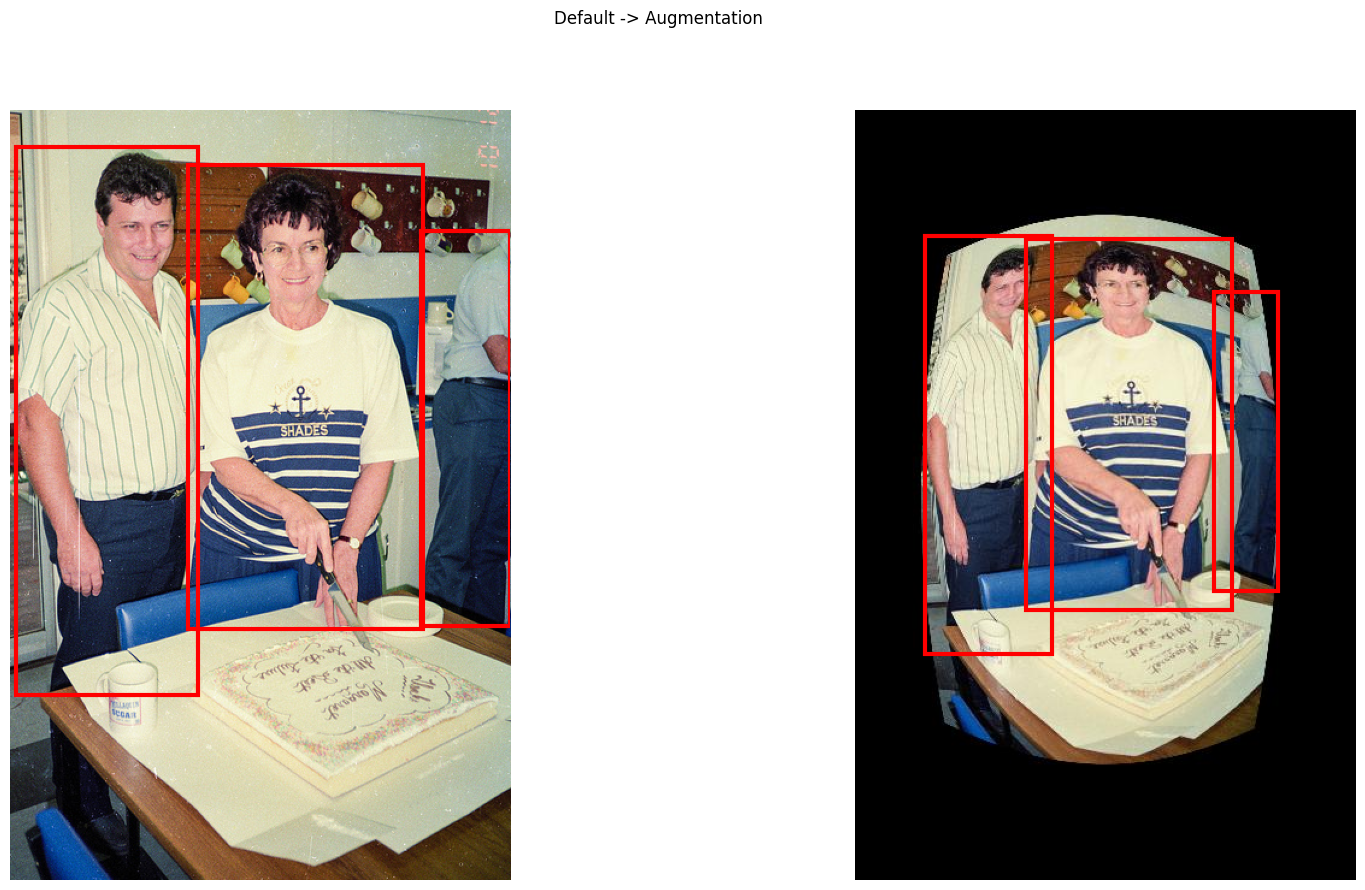

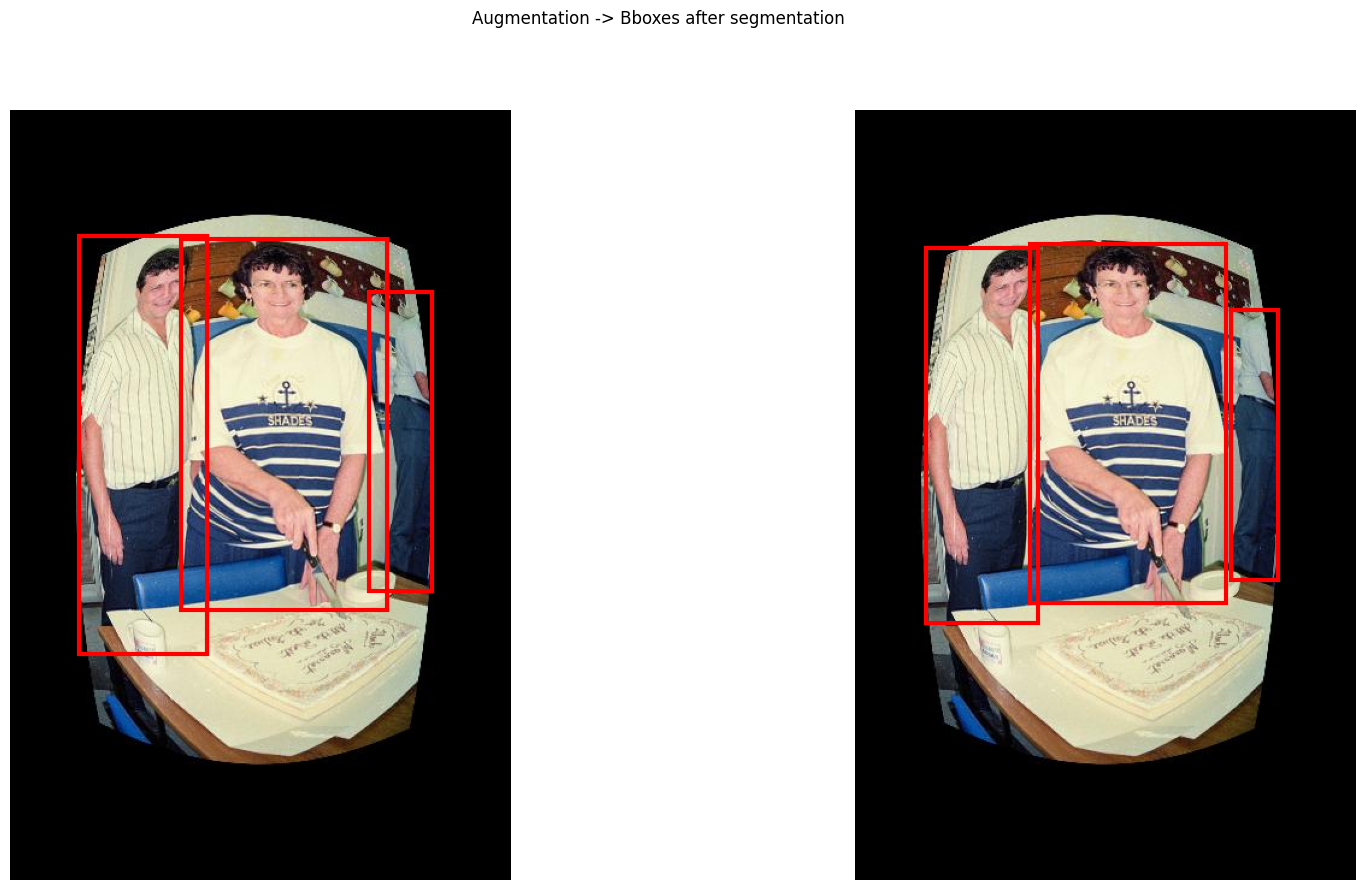

In [11]:
from aug_datasets import save_augmented_copy
from utils.vizualize_bboxes import show_old_and_new_bb

one_image_path="./coco-2017/train/images/000000000113.jpg"
one_image_aug_path="./test_aug_pic.jpg"
one_label_path="./coco-2017/train/labels/000000000113.txt"
one_label_aug_path="./test_aug_label.txt"
ID_CLASS_PERSON_NEW = 0
one_label_seg_path = "./test_seg_label.txt"

save_augmented_copy(
    one_image_path=one_image_path,
    one_image_aug_path=one_image_aug_path,
    one_label_path=one_label_path,
    one_label_aug_path=one_label_aug_path,
)


segment_one_image(ID_CLASS_PERSON_NEW, one_image_aug_path, one_label_aug_path, one_label_seg_path, (20, 10), show_plots=True)

show_old_and_new_bb(one_image_path, one_image_aug_path, one_label_path, one_label_aug_path, (20, 10), 'Default -> Augmentation')

show_old_and_new_bb(one_image_aug_path, one_image_aug_path, one_label_aug_path, one_label_seg_path, (20, 10), 'Augmentation -> Bboxes after segmentation')